# Chapter 12 - Implementing a Multi-layer Artificial Neural Network from Scratch


<center><img src="./images/irobot.jpg" alt="iRobot" style="width: 840px;"/></center>

### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the logistic cost function](#Computing-the-logistic-cost-function)
  - [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Convergence in neural networks](#Convergence-in-neural-networks)
- [Summary](#Summary)

In [ ]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

- Neural network history begins in the 1940s with Warren McCulloch and Walter Pitt
- Rosenblatt's perceptron in the 1950s
    - Still in use
    - Community lost interest until ...
- D.E. Rumelhart G.E. Hinton and R.J. Williams (re)discovered and popularized backpropagation in 1986
    - Interest reduced again with lack of sufficient computing power and rise of competing methods
- After ups and downs, several important discoveries in the late 200Xs and a revolution from around 2012 (+/-)

## Single-layer neural network recap
ADAptive LInear NEuron (Adaline)

<img src="./images/12_01.png" alt="Adaline" style="width: 600px;"/>

### Net input:  
$z = \sum_j w_j x_j = \bf{w^T x}$

### Activation function
For Adaline:  
$\phi (z) = z = a$  
  
(For Logistic Regression:  
$\phi (z) = \frac{1}{1+e^{-z}} = a$)

### Threshold (for Adaline):  
$
\begin{equation}
  \hat{y}=\begin{cases}
    1  \text{ if } g(z) \geq 0\\
    -1  \text{ otherwise}.
  \end{cases}
\end{equation}
$

### Weight update
Gradient descent:  
$\bf{w:=w} + \Delta \bf{w}$, where $\Delta \bf{w} = -\eta \nabla \it{J} \bf{(w)}$,  
i.e. the gradient based on the whole training set, taking a step opposite to the gradient.

Cost function, sum of squared errors (SSE):  
$\it{J} \bf{(w)} = \frac{1}{2}\sum^n_{i=1} (y^{(i)}-\phi (z^{(i)}))^2$

Partial derivative:  
$\frac{\partial}{\partial w_j} \it{J} (\bf{w}) = -\sum_i (y^{(i)} - \phi (z^{(i)}))x^{(i)}_j$,  
where (y, x, a) are (target label, sample and activation).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from adaline import AdalineGD 
from sklearn import datasets, preprocessing

iris = datasets.load_iris()
y_all = pd.DataFrame(iris['target'])
X_all = pd.DataFrame(iris['data'])
classNames = iris['target_names']

# Subset of the Iris data
firstClass = 0; secondClass = 1
y = y_all[(y_all[0] == firstClass) | (y_all[0] == secondClass)]
X = X_all.loc[y.index, [0, 2]].values

y = y.values
y = np.where(y == 0, -1, 1) # Change from 0,1 to -1,1
# Get shape from (100,1) to (100,), needed for boundary plotting function
y = y.reshape((np.shape(y)[0],)) 

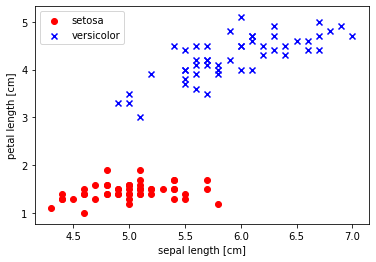

In [2]:
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label=classNames[firstClass])
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label=classNames[secondClass])

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [3]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

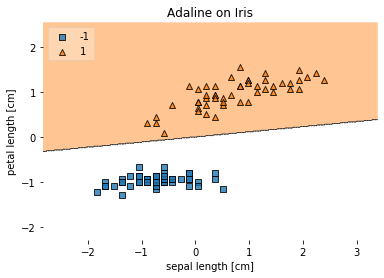

In [10]:
from mlxtend.plotting import plot_decision_regions
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, clf=ada, legend=2)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('Adaline on Iris')
plt.show()

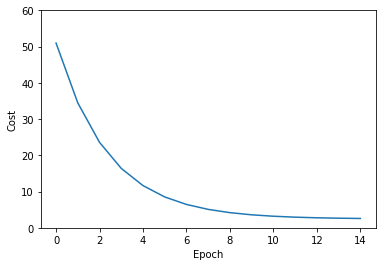

In [26]:
# Plotting the values of the cost function
fig = plt.figure()
plt.plot(ada.cost_)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.ylim([0,60])
plt.show()

### Optimisation
- Gradient descent
- Stochastic gradient descent (SGD)
    - Online learning (random, single sample update)
    - Mini-batch learning (random subset update)
    - Added noise from random overfit can help avoid local minima

In [29]:
import numpy.random as npr
import numpy as np

def func(x):
    return x**2
# n_sample=50, eta=0.1 is beautiful
# n_sample=20, eta=0.01 struggles
def SGD_Sequence_1D(function=func, start=1.0, n_sample=20, eta=0.01, n_updates=20):
    sequence = np.zeros([n_updates,1])
    values   = np.zeros([n_updates,2])
    current  = start
    for i in range(n_updates):
        # New mini-batch
        x = (np.sort(npr.random(n_sample)-0.5)*2) * (abs(start)*2)
        
        # Function values of mini-batch
        y = function(x)
        
        # Add to sequence
        ind = (np.abs(x - current)).argmin()
        sequence[i] = current
        values[i,:] = [x[ind], y[ind]]

        # Find descrete derivative closest to current
        gr = np.gradient(y, x)

        # Update current
        current = current - eta*gr[ind]
    
    return(sequence, values)

In [31]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def SGD_plot(n_updates=10):
    npr.seed(1)
    seq, val = SGD_Sequence_1D(n_updates=n_updates)

    points = val.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.arange(n_updates*1.0)

    fig, axs = plt.subplots()
    norm = plt.Normalize(cols.min(), cols.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs)
    axs.set_xlim(-1.2, 1.2)
    axs.set_ylim(0, 1.2)
    plt.show()

from ipywidgets import interact
import ipywidgets as widgets
interact(SGD_plot, n_updates=widgets.IntSlider(min=2, max=50, step=1, value=2))


interactive(children=(IntSlider(value=2, description='n_updates', max=50, min=2), Output()), _dom_classes=('wi…

<function __main__.SGD_plot(n_updates=10)>

## Introducing the multi-layer neural network architecture
First out: the Multilayer Perceptron (MLP)
- Fully connected network
- $a_h^{(h)}$ should be $a_d^{(h)}$

<img src="./images/12_02.png" alt="Multilayer Percetron" style="width: 600px;"/>  

<img src="./images/12_02.png" alt="Multilayer Percetron" style="width: 600px;"/>  
- $a_i^{(l)}$ = activation unit $i$ in $l$-th layer. 
- $w_{i,j}^{(l)}$ = weight connecting unit $i$ in $l-1$-th layer with unit $j$ in $l$-th layer. These will be grouped into a matrix $W^{(l)}$ later. 
- $i=0$ are bias units (constant/intercept).  
More than one hidden layer => **deep artificial neural network**.

### First layer activation
$a^{(in)} = \begin{bmatrix}a^{(in)}_0 \\ a^{(in)}_1 \\ \vdots \\ a^{(in)}_m\end{bmatrix} = \begin{bmatrix}1 \\ x^{(in)}_1 \\ \vdots \\ x^{(in)}_m\end{bmatrix}$,  
  
i.e. the input and an intercept.  
The bias units of all layers are grouped together as a separate vector later.

### Adding layers
- More layers give higher flexibility
    - Weight matrices, $W^{(l)}$, will have dimension $m \times d$, where $m$ is the number of units in the previous layer (including the bias) and $d$ is the number of units in the $l$-th layer.
- Increases possibility of over-fitting
- Increases number of parameters to estimate (good and bad)
- Error gradients increasingly small
    - Deep learning tools/tricks to overcome this later

### Multiclass classification
- Multiple output units
- Corresponds to one-hot encoding
- Typically a soft-max function on the output:
  - Class probabilities

### 3-4-3 multilayer perceptron
<img src="./images/12_03.png" alt="3-4-3 Perceptron" style="width: 500px;"/>
- "Describe me, please!"

## Activating a neural network via forward propagation
  
Three main steps of fitting an MLP:
1. Forward propagate patterns of the training data from input to output.
2. Calculate error based on a cost function.
3. Backpropagate the error through derivatives with respect to each weight and update the model.  

Repeat for several epochs.

### 1. Forward propagation
Calculation of the first actiavation unit in the (first) hidden layer:  
  
$$z_1^{(h)} = a_0^{(in)} w_{0,1}^{(h)} + a_1^{(in)} w_{1,1}^{(h)} + \dots + a_m^{(in)} w_{m,1}^{(h)}$$  
$$a_1^{(h)} = \phi(z_1^{(h)})$$  
  
$\phi(\cdot)$ is the activation function, differentiable, often non-linear.

### Activation function examples
The basic sigmoid transforms unbounded inputs $z$ to the range $(0,1)$:
<img src="./images/12_04.png" alt="Sigmoid activation" style="width: 500px;"/>  
  
Rectified Linear Units - ReLU (and its siblings) have taken over as the default activiation function in many applications due to their simplicity and beneficial properties.

## Compact notation
For easier readability and more efficient calculations we change from sum-notation to matrix notation. Collect all activation units of layer $l-1$ and all weights for the transition to layer $l$ into matrices:  
$$\bf{Z}^\it{(l)} = \bf{A}^\it{(l-1)} \bf{W}^\it{(l)}$$
  
$$\bf{A}^\it{(l)} = \phi \left(\bf{Z}^\it{(l)} \right)$$

(class eagerly raises hands to define the dimensions)

# Classifying handwritten digits
Revisit MNIST (Modified National Institute of Standards and Technology) database from compulsory assignment 1 in DAT200.  
https://en.wikipedia.org/wiki/MNIST_database  
  
<img src="./images/MnistExamples.png" alt="MNIST digits" style="width: 500px;"/>  

### MNIST
- Derived from the NIST database of B/W handwritten images
- 28x28 bounding box, anti-aliased grayscale images
- 60,000 training images and 10,000 test images 
- Convolutional neural networks have achieved 0.21% error rate with expansion of the training data (1.6% record on raw data).
- Extended MNIST (EMNIST) published in 2017 containing 240,000 training images and 40,000 testing images of digits and characters (https://www.nist.gov/itl/iad/image-group/emnist-dataset).
- Further MNIST-like databases like Zalando Research's fashion images

## Obtaining the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

In this section, we will only be working with a subset of MNIST, thus, we only need to download the training set images and training set labels. 

After downloading the files, simply run the next code cell to unzip the files.



In [32]:
# This code cell unzips mnist
import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb' # add binary to the mode
else:
    writemode = 'w'

# ------ Put the gz-files in the data directory before running this ------ 
zipped_mnist = [f for f in os.listdir('data/') if f.endswith('ubyte.gz')]
print(zipped_mnist)
for z in zipped_mnist:
    with gzip.GzipFile('data/'+z, mode='rb') as decompressed, open('data/'+z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']


In [33]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath: # Read image labels
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath: # Read images, reshape to matrix format and "floatify"
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2 # Normalize to [-1,1]
 
    return images, labels

In [34]:
!ls data

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [36]:
X_train, y_train = load_mnist('data', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [37]:
X_test, y_test = load_mnist('data', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


### Visualize the first digit of each class:

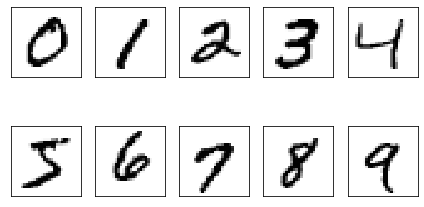

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([]); ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Visualize 25 different versions of "7":

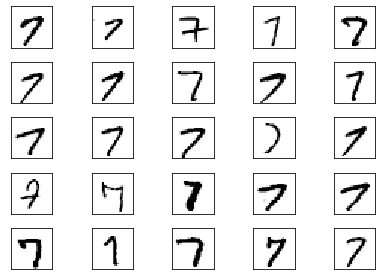

In [39]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([]); ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Save data for later
https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html  
_savez_ uses a compressed (zip) NumPy array format.

In [ ]:
import numpy as np

np.savez_compressed('data/mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [ ]:
mnist = np.load('data/mnist_scaled.npz')
mnist.files

### Split and delete list

In [ ]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

## Implementing a multi-layer perceptron
- The following code is too large for slide presentation
- It contains parts that have not yet been introduced, e.g. backpropagation
    - We will revisit the code later
- Training the MLP on the MNIST data requires around 1.5 seconds per epoch on Liland's computer. Start calculations before going through the code if recommended 200 epochs are used (~5 minutes computing).

In [ ]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch used in the stochastic gradient descent.
        (One gradient update per minibatch)
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

### Train on MNIST
- Training is expensive, especially for deep neural networks
    - Checking performance and tendencies of overfitting on a limited number of epochs and adjusting parameters can save time

In [ ]:
# Around 1.5 seconds per epoch on Liland's computer
n_epochs = 200
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], y_train=y_train[:55000],
       X_valid=X_train[55000:], y_valid=y_train[55000:])

### Visualize cost over epochs

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

Still decreasing after 200 epochs

### Visualize accuracy

In [ ]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.ylabel('Accuracy'); plt.xlabel('Epochs')
plt.legend(); plt.show()

Overfitting from ~50 epochs. Refit with higher regularization, e.g. L2 = 0.1?

### Test set performance

In [ ]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

- Not bad for the autumn's first neural network. Still a little gap to the 98.7% reported in Wikipedia and 99.71% with pre-processing/data augmentation.  
- Tuning tricks include number of hidden units, degree of regularization, learning rate, adaptive learning rate, momentum learning and dropout. More on these later.

### Error analysis
- Mentioned at the end of Feature Selection
- Assess some of the large errors or wrong classifications
- Get an idea of what can be improved
    - Tuning the algorithm
    - Pre-processing (image improvements/morphing)?
    - Extend training data with samples from EMNIST?
- Frown at impossible tasks

In [ ]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([]); ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Training an artificial neural network

We will go deeper into:  
- The cost function
- Backpropagation
- Convergence

## Computing the logistic cost function
The implementation the used same logistic cost functions as Chapter 3 as a basis:
$$\it{J} (w) = -\sum_{i=1}^{n} y^{[i]} log(a^{[i]}) + \left( 1-y^{[i]}\right) log(1-a^{[i]})$$
  
... where $a^{[i]}$ is output of a node for sample [i] in the output layer:
$$a^{[i]} = \phi(z^{[i]})$$

### L2 penalization
$$L2 = \lambda ||w||^2_2 = \lambda \sum_{j=1}^m w^2_j,$$
  
regularizes all weights except the bias units for the node. 

Adding this to the cost results in:
  
$$\it{J} (w) = -\left[ \sum_{i=1}^{n} y^{[i]} log(a^{[i]}) + \left( 1-y^{[i]}\right) log(1-a^{[i]}) \right] + \frac{\lambda}{2} ||w||^2_2$$

### Cost function for all samples and nodes
$$\it{J} (w) = -\sum_{i=1}^{n}\sum_{j=1}^{t} y_j^{[i]} log(a_j^{[i]}) + \left( 1-y_j^{[i]}\right) log(1-a_j^{[i]})$$
  

Adding the L2 norm penalization finally yields:  
  
$$\it{J} (w) = -\left[ \sum_{i=1}^{n}\sum_{j=1}^{t} y_j^{[i]} log(a_j^{[i]}) + \left( 1-y_j^{[i]}\right) log(1-a_j^{[i]}) \right] + \frac{\lambda}{2} \sum_{l=1}^{L-1}\sum_{i=1}^{u_l}\sum_{j=1}^{u_{l+1}}\left(w_{j,i}^{(l)}\right)^2$$

In [ ]:
def _compute_cost(self, y_enc, output):
    L2_term = (self.l2 *
               (np.sum(self.w_h ** 2.) +
                np.sum(self.w_out ** 2.)))

    term1 = -y_enc * (np.log(output))
    term2 = (1. - y_enc) * np.log(1. - output)
    cost = np.sum(term1 - term2) + L2_term
    return cost

### One-hot encoding representation
The activation of the third layer and the target class for __a particular__ sample may look like this:
$$a^{(out)} = \begin{bmatrix}0.1 \\ 0.9 \\ \vdots \\ 0.3\end{bmatrix}, y = \begin{bmatrix}0 \\ 1 \\ \vdots \\ 0\end{bmatrix}$$

In [ ]:
def predict(self, X):
    z_h, a_h, z_out, a_out = self._forward(X)
    y_pred = np.argmax(z_out, axis=1) # argmax on z_out and a_out is equivalent
    return y_pred

### Cost minimization
... will be performed using the partial derivative of the parameters of $W$ with respect to each weight for every layer:
$$\frac{\partial}{\partial w_{j,i}^{(l)}}J(W)$$

<img src="./images/12_10.png" alt="W in layers" style="width: 400px;"/>
... where each $W^{(l)}$ may have different dimensions.

## Developing your intuition for backpropagation
- Backpropagation is still one of the most popular algorithms to train ANNs
- Challenging with high dimensions and non-convex cost function (local minima)
- Main building block: "The chain rule"
    - Derivative of a nested function
$$\frac{d}{dx}[f(g(x))] = \frac{df}{dg}\cdot\frac{dg}{dx}$$

$$F(x) = f(g(h(u(v(x)))))$$
  
$$\frac{dF}{dx} = \frac{d}{dx}F(x) = \frac{d}{dx}[f(g(h(u(v(x)))))] = \frac{df}{dg}\cdot\frac{dg}{dh}\cdot\frac{dh}{du}\cdot\frac{du}{dv}\cdot\frac{dv}{dx}$$

### Deriving everything by hand
- ... is something we can avoid
- Automatic differentiation
    - Simple function derivatives can be coded as matrices
    - Starting from the left would yields a number of matrix products times a vector (forward mode)
    - Starting from the right all products are of the form matrix times vector (reverse mode)
        - Dimension collapse => high speed

## Training neural networks via backpropagation
Forward-propagation of input features through:  
$Z^{(h)}=A^{(in)}W^{(h)}$ : net input of the hidden layer  
$A^{(h)}=\phi(Z^{(h)})$ : activation of the hidden layer  
$Z^{(out)}=A^{(h)}W^{(out)}$ : net input of the output layer  
$A^{(out)}=\phi(Z^{(out)})$ : activation of the output layer  
<img src="./images/12_11.png" alt="Feed forward" style="width: 400px;"/>  

### Error propagation
Backpropagation - propagate the error from right to left.  
Calculate the error vector (nxt): 
$$\delta^{(out)} = a^{(out)}-y.$$  
  
Calculate the error of the hidden layer by propagation, transforming the errors backwards through the network:
$$\delta^{(h)} = \delta^{(out)}(W^{(out)})^T \odot \frac{\partial\phi(z^{(h)})}{\partial z^{(h)}}$$

The derivative of the sigmoid function:  
$$\frac{\partial\phi(z^{(h)})}{\partial z^{(h)}} = (a^{(h)} \odot (1-a^{(h)}))$$
  
... because:  
$$\phi'(z) = \frac{\partial}{\partial z} \left( \frac{1}{1+e^{-z}} \right) = \frac{1}{1+e^{-z}} - \left( \frac{1}{1+e^{-z}} \right)^2$$  
  
$$= \phi(z) - (\phi(z))^2 = \phi(z)(1-\phi(z)) = a(1-a)$$

### Error propagation, hidden layer
$$\delta^{(h)} = \delta^{(out)}(W^{(out)})^T \odot \frac{\partial\phi(z^{(h)})}{\partial z^{(h)}}$$  
  
$$ = \delta^{(out)}(W^{(out)})^T \odot (a^{(h)} \odot (1-a^{(h)}))$$  
  
... where $\delta^{(out)}$ has dimensions (nxt), $W^{(out)}$ has dimensions (hxt) and $\delta^{(h)}$ has dimensions (nxh).  
(sigma_h in the code)

In [ ]:
def errors():
    sigma_out = a_out - y_train_enc[batch_idx]

    # [n_samples, n_hidden]
    sigmoid_derivative_h = a_h * (1. - a_h)

    # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
    # -> [n_samples, n_hidden]
    sigma_h = (np.dot(sigma_out, self.w_out.T) *
               sigmoid_derivative_h)


### Derivative of the cost function
$$\frac{\partial}{\partial w_{i,j}^{(out)}} J(W) = a_j^{(h)}\delta_i^{(out)}$$
$$\frac{\partial}{\partial w_{i,j}^{(h)}} J(W) = a_j^{(in)}\delta_i^{(h)}$$

... in vectorized format with regularization terms:  
$$\Delta^{(h)} = \left( A^{(in)} \right)^T \delta^{(h)} + \lambda^{(h)}$$
$$\Delta^{(out)} = \left( A^{(h)} \right)^T \delta^{(out)} + \lambda^{(out)}$$
(delta_w_out and delta_w_h in the code, grad_w_.. + regularization)

In [ ]:
def gradients():
    ## GRADIENTS ##
    # [n_features, n_samples] dot [n_samples, n_hidden]
    # -> [n_features, n_hidden]
    grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
    grad_b_h = np.sum(sigma_h, axis=0)

    # [n_hidden, n_samples] dot [n_samples, n_classlabels]
    # -> [n_hidden, n_classlabels]
    grad_w_out = np.dot(a_h.T, sigma_out)
    grad_b_out = np.sum(sigma_out, axis=0)

    # Regularization and weight updates
    delta_w_h = (grad_w_h + self.l2*self.w_h)
    delta_b_h = grad_b_h # bias is not regularized

    delta_w_out = (grad_w_out + self.l2*self.w_out)
    delta_b_out = grad_b_out  # bias is not regularized


### Weight update
$$W^{(l)}:=W^{(l)} - \eta \Delta^{(l)}$$  
  
A small step in the opposite direction of the gradient (for each layer in the network).

In [ ]:
def backprop():
    ## ERRORS ##
    # [n_samples, n_classlabels]
    sigma_out = a_out - y_train_enc[batch_idx]

    # [n_samples, n_hidden]
    sigmoid_derivative_h = a_h * (1. - a_h)

    # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
    # -> [n_samples, n_hidden]
    sigma_h = (np.dot(sigma_out, self.w_out.T) *
               sigmoid_derivative_h)

    ## GRADIENTS ##
    # [n_features, n_samples] dot [n_samples, n_hidden]
    # -> [n_features, n_hidden]
    grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
    grad_b_h = np.sum(sigma_h, axis=0)

    # [n_hidden, n_samples] dot [n_samples, n_classlabels]
    # -> [n_hidden, n_classlabels]
    grad_w_out = np.dot(a_h.T, sigma_out)
    grad_b_out = np.sum(sigma_out, axis=0)

    # Regularization and weight updates
    delta_w_h = (grad_w_h + self.l2*self.w_h)
    delta_b_h = grad_b_h # bias is not regularized
    self.w_h -= self.eta * delta_w_h
    self.b_h -= self.eta * delta_b_h

    delta_w_out = (grad_w_out + self.l2*self.w_out)
    delta_b_out = grad_b_out  # bias is not regularized
    self.w_out -= self.eta * delta_w_out
    self.b_out -= self.eta * delta_b_out

<img src="./images/12_12.png" alt="Back propagation" style="width: 500px;"/>  
Go through fit function one more time.

# Convergence in neural networks
- Gradient descent with mini-batch instead of stochastic gradient descent (Ch. 2, p.44)
    - Efficient vectorized code
    - Like a "meningsmåling ved valg" / election poll
    - Still stochastic, hopefully jumping out of local minima
- Learning rate: fixed rate $\eta$
    - Deep Learning brings adaptive learning rate, learning rate with decay, learning rate with restarts, ...

<img src="./images/12_13.png" alt="Convergence" style="width: 500px;"/>  

# Summary
- Expanded perceptron to multilayer perceptron
    - Varying numbers of units (input, hidden, hidden, ..., output)
    - SGD -> mini-batch
    - Forward propagation of features
    - Backpropagation of errors (chain rule)
    - Developed the gradient of the cost function for all weights in the network
- Non-exhaustive list of activation functions on page 450.